In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import data
import tfrecords_generator
import importlib
importlib.reload(data)
importlib.reload(tfrecords_generator)

from tfrecords_generator import write_data
from data import gen_fcst_norm 
#from memory_profiler import memory_usage
import numpy as np

import warnings
warnings.filterwarnings('ignore')

years = [2023]
interval = 0.1

#mem = memory_usage((gen_fcst_norm, (year,)), interval=interval)
#time = np.arange(len(mem)) * interval
#mem_file = "log_memory_generating_norm.dat"

#np.savetxt(mem_file, np.array((time, mem)).T)

for year in years:
    #mem = memory_usage((write_data, (year,)), interval=interval)
    write_data(year,consolidated=True)
    #time = np.arange(len(mem)) * interval
    #mem_file = "/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/cGAN/tfrecords/log_memory_writing_data_%s.dat"%year

    #np.savetxt(mem_file, np.array((time, mem)).T)


2024-10-11 19:30:47.000358: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-11 19:30:47.015401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-11 19:30:47.030856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-11 19:30:47.035485: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-11 19:30:47.046912: I tensorflow/core/platform/cpu_feature_guar

Samples per image: 8
Doing time index 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [30:00<00:00, 15.01s/it]


Doing time index 36


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [25:10<00:00, 12.59s/it]


Doing time index 42


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [25:15<00:00, 12.63s/it]


Doing time index 48


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [24:19<00:00, 12.16s/it]


In [3]:
from xarray_batcher import get_fcst_and_truth as gfat

In [4]:
from xarray_batcher.batcher import zarr_store_loader, batch_from_zarr_store

In [3]:
import pickle

with open(f'/network/home/n/nath/cGAN/constants-regICPAC/FCSTNorm2021.pkl', 'rb') as f:
    norm = pickle.load(f)

norm['Convective available potential energy']
    

{'min': 0.0,
 'max': 5060.9165,
 'mean': 353.36827374192967,
 'std': 576.8885141782403}

In [3]:
import data
import importlib
importlib.reload(data)
from data import load_truth_and_mask

truth, mask = np.mean(np.stack(([load_truth_and_mask(str(date).replace('-',''), 36) for date in np.arange('2021-04-01', '2021-04-02', np.timedelta64(1,'D'), dtype='datetime64')])),axis=0)




['/network/group/aopp/predict/TIP021_MCRAECOOPER_IFS/IMERG_V07/ICPAC_region/6h/20210402_12.nc']


In [2]:
import glob
import xarray as xr

TRUTH_PATH = '/network/group/aopp/predict/TIP018_HARRIS_TENSORFL/IMERG-regICPAC-6hr/'
data_path = glob.glob(TRUTH_PATH+"*.nc4")

ds = xr.open_mfdataset(data_path[0])
#print(ds)

lat_reg_IMERG = ds.lat.values
lon_reg_IMERG = ds.lon.values


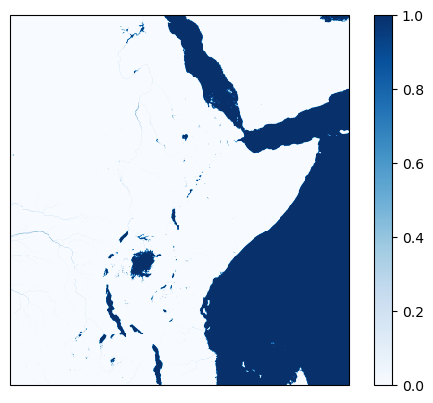

In [78]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ax = plt.axes(projection = ccrs.PlateCarree())

mesh = ax.pcolormesh(lon_reg_IMERG, lat_reg_IMERG, np.squeeze(elev)[:,:,1], cmap='Blues')
plt.colorbar(mesh)

In [75]:
from data import load_hires_constants

elev = load_hires_constants(batch_size=1)

In [76]:
elev.shape

(1, 384, 352, 2)

In [80]:
import data_generator
import importlib
importlib.reload(data_generator)
from data_generator import DataGenerator

from data import all_fcst_fields

dates = data.get_dates(2021, 30, 54)

dgc = DataGenerator(dates[80:],
                       fcst_fields=all_fcst_fields,
                                start_hour=36,
                                end_hour=42,
                                batch_size=1,
                                log_precip=True,
                                shuffle=False,
                                constants=True,
                                fcst_norm=True)

sample = dgc.__getitem__(0)



2021-01-01 2022-01-04


In [17]:
sample = dgc.__getitem__(5)

Convective precipitation (water)
Convective precipitation (water)
Total Precipitation
Total Precipitation


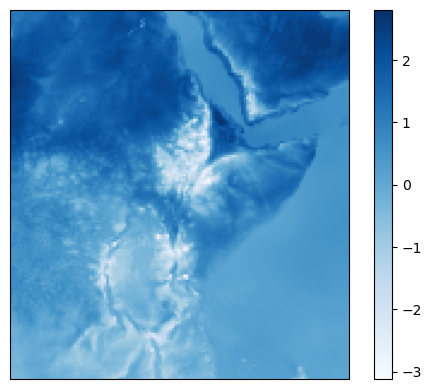

In [82]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

ax = plt.axes(projection = ccrs.PlateCarree())

mesh = ax.pcolormesh(lon_reg_IMERG, lat_reg_IMERG, np.squeeze(sample[0]['lo_res_inputs'])[:,:,23], cmap='Blues')
plt.colorbar(mesh)

In [43]:
(np.isnan(np.squeeze(sample[0]['lo_res_inputs']))).sum()

0

In [7]:
sample[0]['lo_res_inputs'].shape

(1, 384, 352, 56)

In [69]:
import tensorflow as tf
from tfrecords_generator import _parse_batch

dataset = tf.data.TFRecordDataset('/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/cGAN/tfrecords/2021_36.3.tfrecords',compression_type='GZIP')




In [70]:
#dataset = dataset.shuffle(64)
dataset = dataset.map(lambda x: _parse_batch(x, insize = (128,128,56), consize=(128,128,2), outsize=(128,128,1)))
            

In [71]:
test = dataset.repeat().batch(2)

In [72]:
for inputs,outputs in test.take(1).as_numpy_iterator():

    print(inputs)

    break

{'lo_res_inputs': array([[[[ 0.36278015,  0.38372496,  0.15965487, ...,  0.785359  ,
           0.31622183,  0.54863477],
         [ 0.36278015,  0.38372496,  0.15965487, ...,  0.785359  ,
           0.31622183,  0.54863477],
         [ 0.38160095,  0.4704193 ,  0.14068586, ...,  0.6811543 ,
           0.47252882,  0.5428456 ],
         ...,
         [ 0.08654559,  0.33590755,  0.00691574, ...,  1.75793   ,
           2.0066428 ,  1.7913644 ],
         [ 0.08654559,  0.33590755,  0.00691574, ...,  1.75793   ,
           2.0066428 ,  1.7913644 ],
         [ 0.13633831,  0.30671358,  0.02143862, ...,  1.7231958 ,
           1.9024401 ,  1.6350602 ]],

        [[ 0.36278015,  0.38372496,  0.15965487, ...,  0.785359  ,
           0.31622183,  0.54863477],
         [ 0.36278015,  0.38372496,  0.15965487, ...,  0.785359  ,
           0.31622183,  0.54863477],
         [ 0.38160095,  0.4704193 ,  0.14068586, ...,  0.6811543 ,
           0.47252882,  0.5428456 ],
         ...,
         [ 0.086

In [ ]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["KERAS_BACKEND"] = "tensorflow"
from noise import NoiseGenerator
from data import denormalise

import setupmodel
import importlib
importlib.reload(setupmodel)
from setupmodel import setup_model

import yaml
from tqdm import tqdm
import read_config
from tensorflow.keras.utils import Progbar
from data import (
    HOURS,
    all_fcst_fields,
    accumulated_fields,
    nonnegative_fields,
    fcst_norm,
    logprec,
    denormalise,
    load_hires_constants,
)

import xarray as xr
import numpy as np

model_folder='logfile/'

# Open and parse GAN config file
config_path = os.path.join(model_folder, "setup_params.yaml")
with open(config_path, "r") as f:
    try:
        setup_params = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        print(exc)

downscaling_steps = read_config.read_downscaling_factor()["steps"]

mode = setup_params["GENERAL"]["mode"]
arch = setup_params["MODEL"]["architecture"]
padding = setup_params["MODEL"]["padding"]
filters_gen = setup_params["GENERATOR"]["filters_gen"]
noise_channels = setup_params["GENERATOR"]["noise_channels"]
latent_variables = setup_params["GENERATOR"]["latent_variables"]
filters_disc = setup_params["DISCRIMINATOR"]["filters_disc"]  # TODO: avoid setting up discriminator in forecast mode?
constant_fields = 2

assert mode == "GAN", "standalone forecast script only for GAN, not VAE-GAN or deterministic model"

# Set up pre-trained GAN
weights_fn = os.path.join(model_folder, 'models', f"gen_weights-0115200.h5")
input_channels = 4*len(all_fcst_fields)

model = setup_model(mode=mode,
                    arch=arch,
                    downscaling_steps=downscaling_steps,
                    input_channels=input_channels,
                    constant_fields=constant_fields,
                    filters_gen=filters_gen,
                    filters_disc=filters_disc,
                    noise_channels=noise_channels,
                    latent_variables=latent_variables,
                    padding=padding)
gen = model.gen
gen.load_weights(weights_fn)
network_const_input = load_hires_constants(batch_size=1)
field_arrays = []

input_folder_year = "/network/group/aopp/predict/TIP022_NATH_GFSAIMOD/netcdf/2023/"
ensemble_members = 50
# the contents of the next loop are v. similar to load_fcst from data.py,
# but not quite the same, since that has different assumptions on how the
# forecast data is stored.  TODO: unify the data normalisation between these?
for field in all_fcst_fields.keys():
    # Original:
    # nc_in[field] has shape 1 x 50 x 29 x 384 x 352
    # corresponding to n_forecasts x n_ensemble_members x n_valid_times x n_lats x n_lons
    # Ensemble mean:
    # nc_in[field] has shape len(nc_in["time"]) x 29 x 384 x 352
    
    # Open input netCDF file
    input_file = f"{all_fcst_fields[field]}.zarr"
    #input_file = 'IFS_20180606_00Z.nc'
    #input_file = f'IFS_{d.year}{d.month:02}{d.day:02}_00Z.nc'
    nc_in_path = os.path.join(input_folder_year, input_file)
    nc_in = xr.open_zarr(nc_in_path)#.sel({'time':f"{d.year}-{d.month:02}-{d.day:02}"})#nc.Dataset(nc_in_path, mode="r")

    #print(nc_in.time.values)
    data = np.moveaxis(np.squeeze(nc_in.isel({"time":[35]}).to_dataarray().values),0,-1)
    
    field_arrays.append(data)

network_fcst_input = np.concatenate(field_arrays, axis=-1)  # lat x lon x 4*len(all_fcst_fields)
network_fcst_input = np.expand_dims(network_fcst_input, axis=0)  # 1 x lat x lon x 4*len(...)

noise_shape = network_fcst_input.shape[1:-1] + (noise_channels,)
noise_gen = NoiseGenerator(noise_shape, batch_size=1)
predictions = []
#progbar = Progbar(ensemble_members)
for ii in tqdm(range(ensemble_members),total=ensemble_members):
    gan_inputs = [np.asarray(network_fcst_input), np.asarray(network_const_input), np.asarray(noise_gen())]
    gan_prediction = gen.predict(gan_inputs, verbose=2)  # 1 x lat x lon x 1
    predictions.append(denormalise(gan_prediction[0, :, :, 0]))
    #progbar.add(1)

2024-10-07 17:15:17.136320: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 17:15:17.152108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 17:15:17.167680: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 17:15:17.172344: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 17:15:17.183558: I tensorflow/core/platform/cpu_feature_guar

In [2]:
np.empty(shape=3,dtype=np.float64)

array([4.63840860e-310, 0.00000000e+000, 4.63825869e-310])

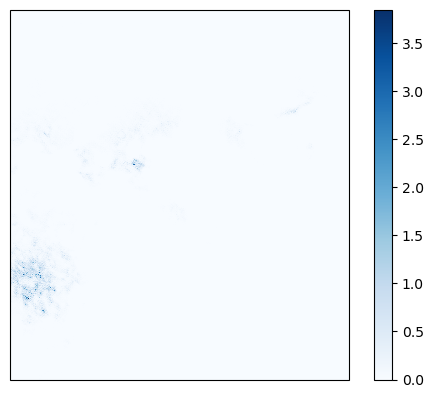

In [85]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import glob


TRUTH_PATH = '/network/group/aopp/predict/TIP018_HARRIS_TENSORFL/IMERG-regICPAC-6hr/'
data_path = glob.glob(TRUTH_PATH+"*.nc4")

ds = xr.open_mfdataset(data_path[0])
#print(ds)

lat_reg_IMERG = ds.lat.values
lon_reg_IMERG = ds.lon.values

ax = plt.axes(projection = ccrs.PlateCarree())

mesh = ax.pcolormesh(lon_reg_IMERG, lat_reg_IMERG, predictions[0,2,0,:,:]*1000, cmap='Blues')
plt.colorbar(mesh)

In [45]:
from data import load_fcst_norm

load_fcst_norm(2021)

{'Convective available potential energy': {'min': 0.0,
  'max': 5060.9165,
  'mean': 353.36827374192967,
  'std': 576.8885141782403},
 'Convective precipitation (water)': {'min': 0.0,
  'max': 10942.708,
  'mean': 221.19678806460806,
  'std': 510.6248432421585},
 'Medium cloud cover': {'min': 0.0,
  'max': 100.0,
  'mean': 18.048821338712706,
  'std': 26.28508984502161},
 'Surface pressure': {'min': 66547.43,
  'max': 102703.49,
  'mean': 94929.37199037352,
  'std': 5486.265313158451},
 'Upward short-wave radiation flux': {'min': 0.0,
  'max': 289.14667,
  'mean': 43.595493802276515,
  'std': 57.628844801216125},
 'Downward short-wave radiation flux': {'min': 0.35599998,
  'max': 722.91364,
  'mean': 264.80159996631585,
  'std': 256.85152430546674},
 '2 metre temperature': {'min': 274.87875,
  'max': 319.77393,
  'mean': 299.4504116180272,
  'std': 5.612859447433858},
 'Cloud water': {'min': 0.0,
  'max': 2.7919734,
  'mean': 0.04932853633297358,
  'std': 0.11816838266414283},
 'Precip

In [ ]:
gen.weights[-2]